In [45]:
import numpy as np
from fish.ephys import ephys
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections
from skimage import io
from scipy.stats import zscore
from numpy import convolve
from scipy.signal import gaussian
import os
%matplotlib inline

In [46]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    
def estimate_threshold(vec, window=180000, scaling=1.6):    
    """
    Return non-sliding windowed threshold of input ndarray vec
        
    vec : ndarray, input array to be thresholded
    window : step size / window length of the thresholding
    scaling : scaling factor applied to estimated spread of the noise distribution of vec, sets magnitude of threshold
    """
    from numpy import zeros, percentile, arange, median
    
    th = zeros(vec.shape)    
    for t in arange(0, vec.size-window, window):
        plr = arange(t, min(t+window, vec.size))
        sig = vec[plr]            
        med = median(sig)
        bottom = percentile(sig, .01)
        th[t:] = (med + scaling * (med - bottom))
    
    return th

def prepare_swim(swims, threshold=False):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance
    
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[0] for s in swims]
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts -= ts.min()
    ts /= ts.max()
    
    if threshold:
        th = estimate_threshold(ts)
        ts[ts < th] = 0
    
    return ts

def prepare_data(fname, fs_ep, fused_roi):
    # load and process ephys data    
    from fish.ephys.ephys import load, chop_trials
    from scipy.signal import fftconvolve
    
    processed = {}
    dat = load(fname)
    swims = dat[0:2].copy()
    laser_signal = dat[6].copy()
    trial_signal = dat[4].copy()

    swim_pow = prepare_swim(swims, threshold=True)    
    kern_smooth = gaussian(2 * fs_ep, 1000)
    kern_smooth /= kern_smooth.sum()
    swim_pow_smooth = fftconvolve(swim_pow, kern_smooth, mode='same')
    processed['laser_signal'] = laser_signal
    processed['trial_signal'] = trial_signal
    processed['raw'] = swims
    processed['swim_power'] = swim_pow
    processed['swim_power_smoothed'] = swim_pow_smooth
        
    laser = chop_trials(laser_signal)
    on_val = max(list(laser.keys()))

    if fused_roi:
        for val in np.arange(2, len(np.unique(trial_signal)), 2):
            trial_signal[trial_signal == val] = val-1
        
    rois = chop_trials(trial_signal)
    conds = [int(x) for x in rois if x > 0]
    processed['conds'] = conds
    processed['trials'] = rois

    return processed

In [47]:
pos_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/'
neg_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/neg/'
proc_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/'

if not os.path.exists(proc_dir):
    os.makedirs(proc_dir)

In [48]:
from os.path import split, sep
from itertools import chain

fnames = {}
fnames['pos'] = glob(pos_dir + '*/*.10chFlt')
fnames['pos'].sort()

fnames['neg'] = glob(neg_dir + '*/*.10chFlt')
fnames['neg'].sort()

#exp_dirs = [split(f)[0] + sep for f in fnames_ep]

for ind, f in enumerate(fnames['pos']):
    print('Pos: {0} : {1}'.format(ind, f))
    
for ind, f in enumerate(fnames['neg']):
    print('Neg: {0} : {1}'.format(ind, f))
    
sampling_rates = [6000] * (len(fnames['pos']) + len(fnames['neg']))

Pos: 0 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20160315/20170315_1_9_gfapcochr_hucrgeco_5dpf_laser65_smallROIs.10chFlt
Pos: 1 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170316/20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR.10chFlt
Pos: 2 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170320/20170320_2_6_g1_r1_7dpf_laser65.10chFlt
Pos: 3 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170321/20170321_1_3_g1_r1_6dpf_laser65_20ms.10chFlt
Pos: 4 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170330/20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6.10chFlt
Pos: 5 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170330/6dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt
Pos: 6 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170331/20170331_f1_g1_7dpf_6.10chFlt
Pos: 7 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/20170405/7dpf_cy252xcy293_f1_g1_omr_opto_1.10chFlt
Pos: 8 : /groups/ahrens/ahrenslab/projects/ngm/ephys/opto/

In [49]:
%%time
#prepped = [prepare_data(val, fs_ep = sampling_rates[ind], fused_roi = True) for ind, val in enumerate(fnames_ep)]
prepped = {}
prepped['pos'] = [prepare_data(val, fs_ep = 6000, fused_roi = True) for ind, val in enumerate(fnames['pos'])]
prepped['neg'] = [prepare_data(val, fs_ep = 6000, fused_roi = True) for ind, val in enumerate(fnames['neg'])]

Data needed to be truncated!
Data needed to be truncated!
Data needed to be truncated!
CPU times: user 5min 18s, sys: 1min 32s, total: 6min 51s
Wall time: 6min 51s


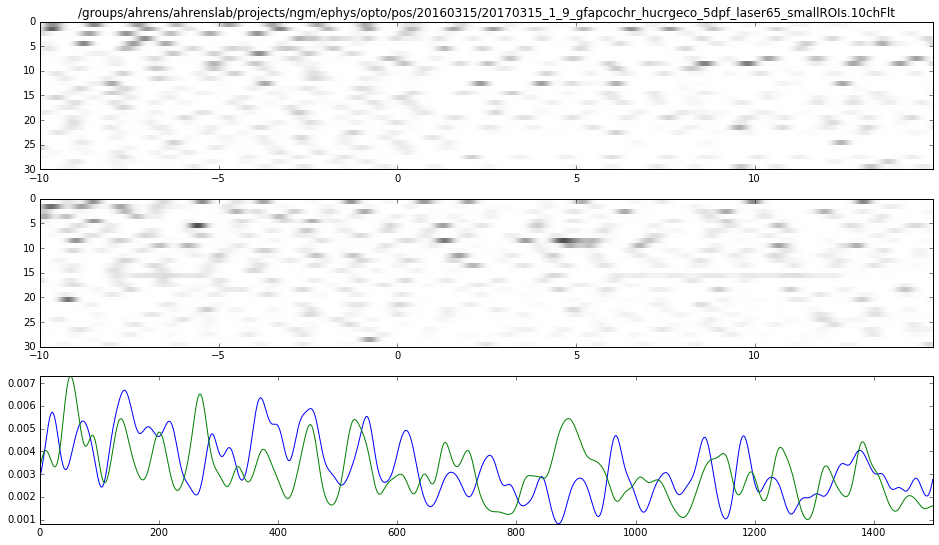

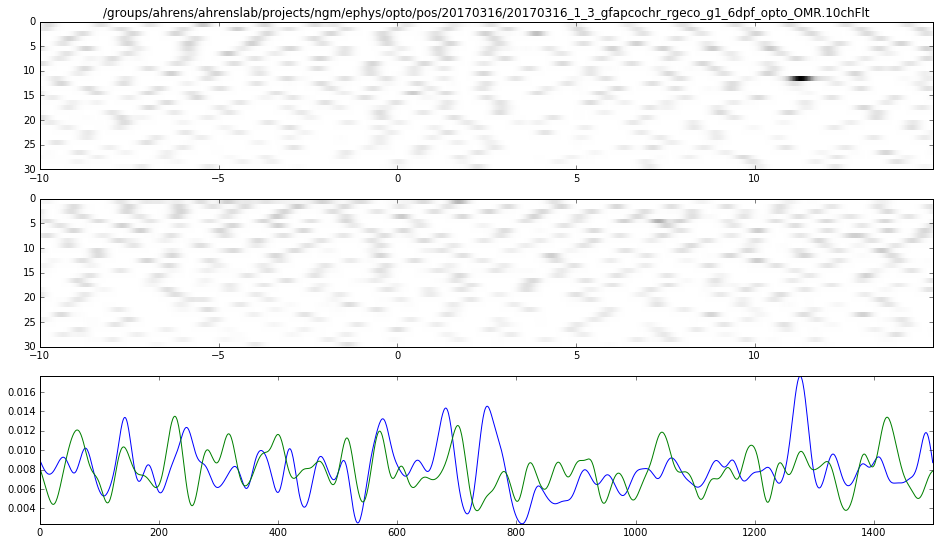

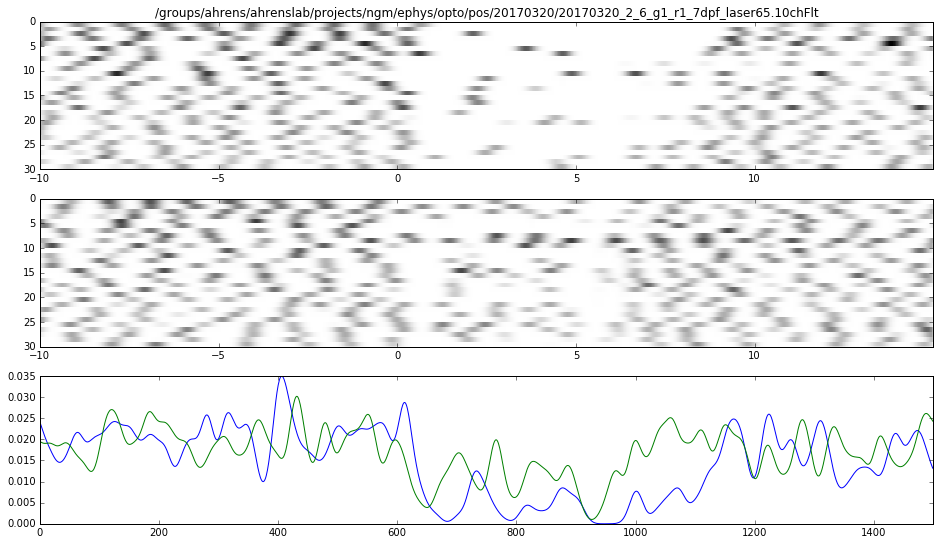

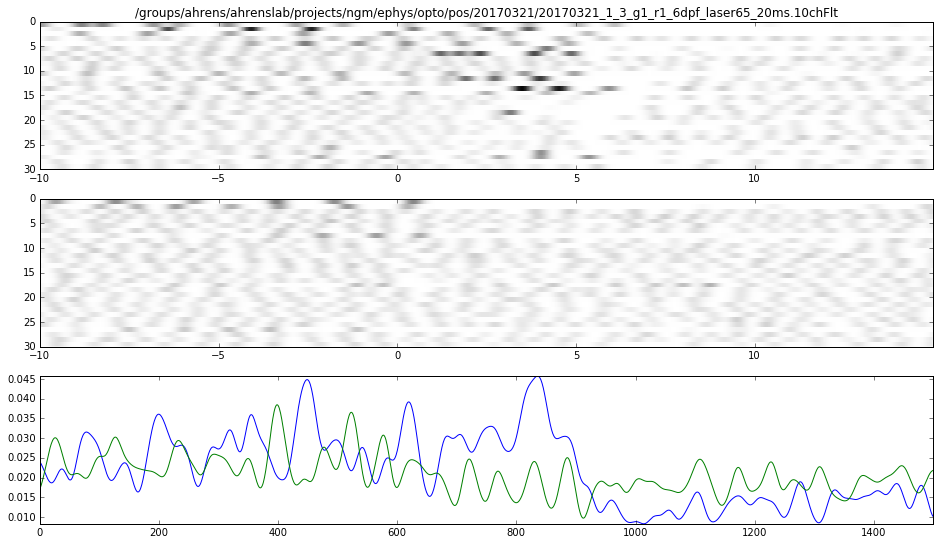

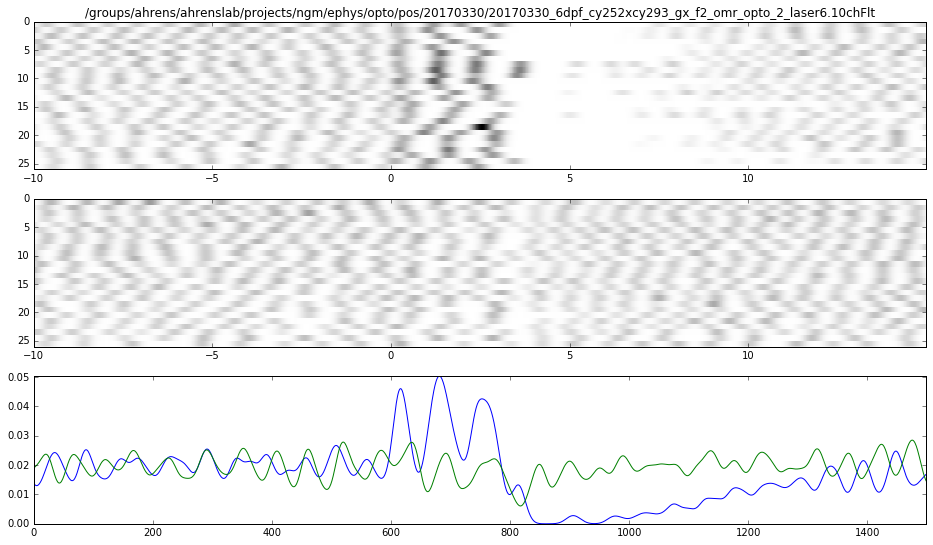

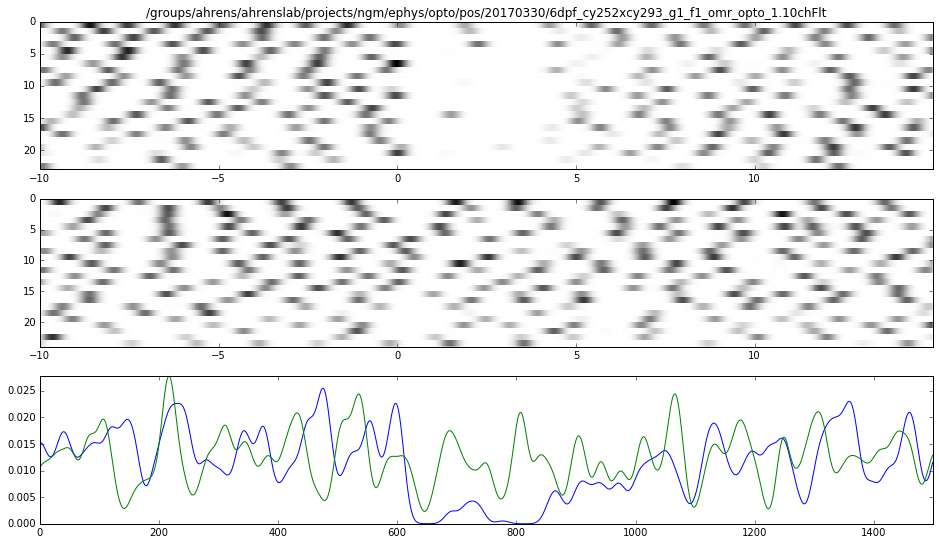

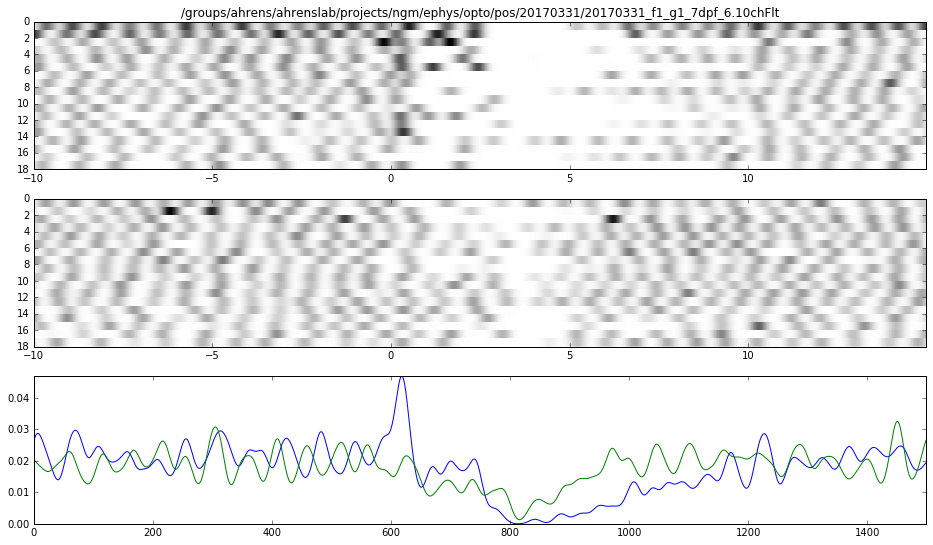

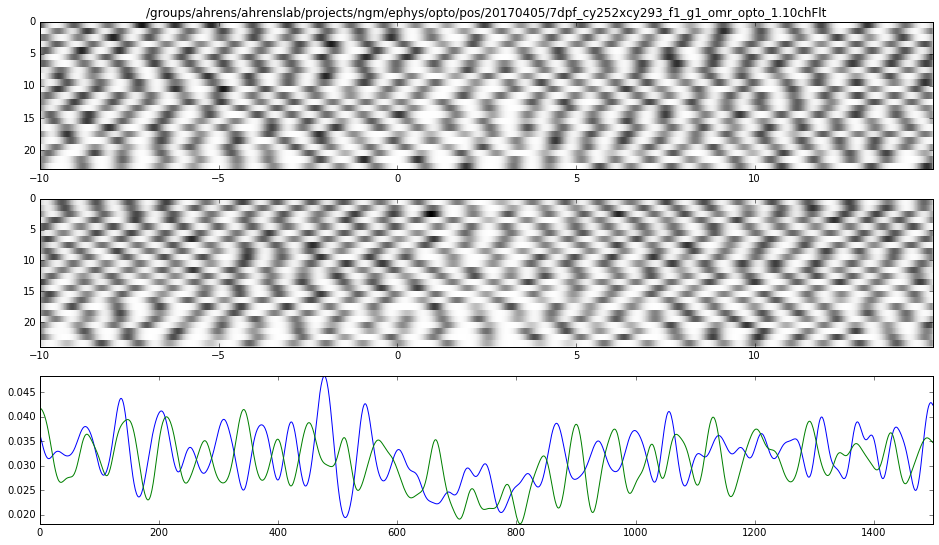

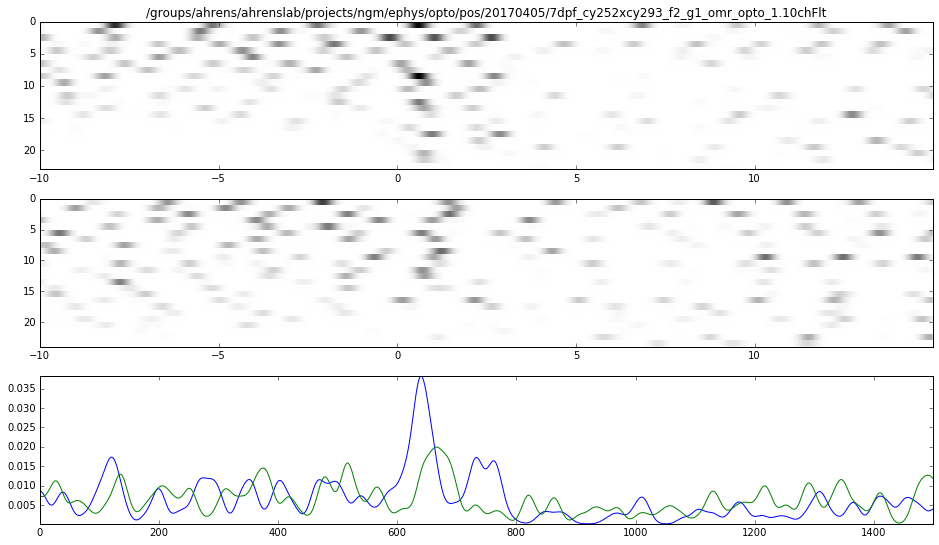

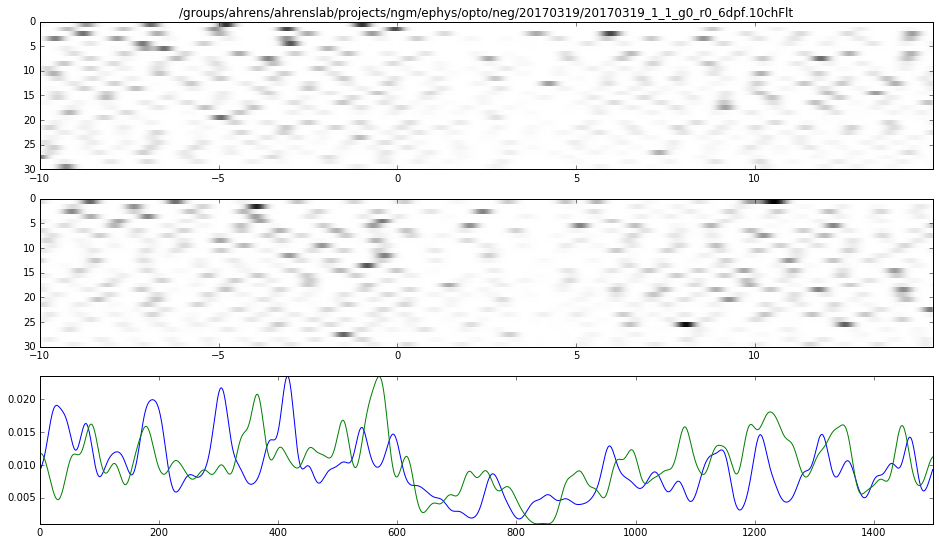

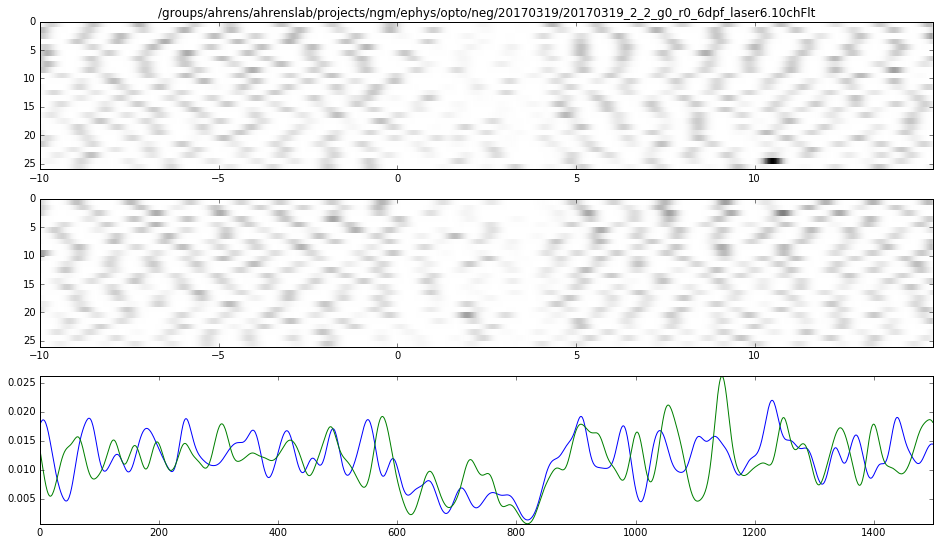

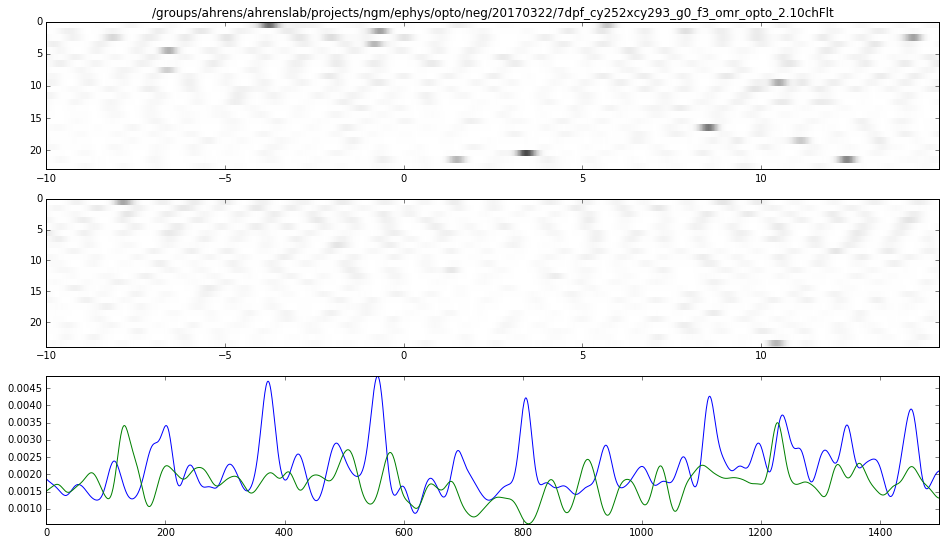

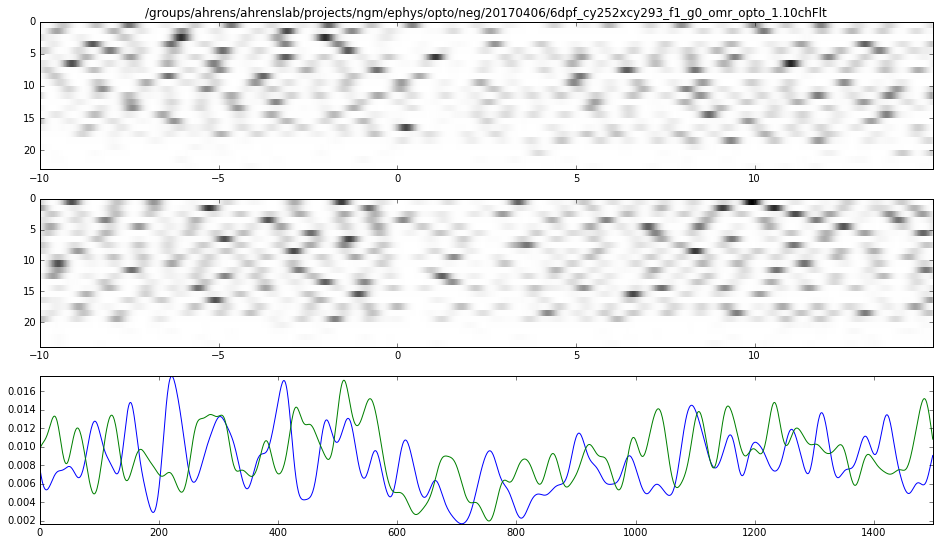

In [50]:
def raster_plot(data, fs_ep, title):  
    to_compare = [1,3]
    fig, axs = plt.subplots(nrows=1 + len(to_compare), figsize=(16,9))
    ds_ep = 100
    window = np.arange(-fs_ep * 10, fs_ep * 15, ds_ep)
    onset = np.where(window >= 0)[0][0]
        
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        to_plot = data['swim_power_smoothed'][trials]    

        # order by swim power before stimulation
        plot_order = np.argsort(to_plot[:,:onset].mean(1))[::-1][slice(0, 30)]        
        to_plot = to_plot[plot_order,:]
        
        clims = (data['swim_power_smoothed'].min(), data['swim_power_smoothed'].max())
        axs[ind].imshow(to_plot, cmap='gray_r', interpolation='None', extent=(window[0] / fs_ep, window[-1] / fs_ep, to_plot.shape[0], 0), aspect='auto', clim=clims)
        axs[-1].plot(to_plot.mean(0))
        #axs[-1].plot(prepped['trial_signal'][trials].mean(0))
        axs[-1].axis('tight')
        axs[0].title.set_text(title)
        
[raster_plot(p, sampling_rates[ind], fnames['pos'][ind]) for ind, p in enumerate(prepped['pos'])];
[raster_plot(p, sampling_rates[ind], fnames['neg'][ind]) for ind, p in enumerate(prepped['neg'])];

In [51]:
# Average all recordings
window = np.arange(-6000 * 10, 6000 * 15, 1)

def data_gather(data, fs_ep, window):  
    to_compare = [1,3]    
    to_keep = slice(0, 30)
    onset = np.where(window >= 0)[0][0]
    output_trials = []
    
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        sub_data = data['swim_power_smoothed'][trials]    

        # order by swim power before stimulation
        plot_order = np.argsort(sub_data[:,:onset].mean(1))[::-1][to_keep]        
        sub_data = sub_data[plot_order,:]
        output_trials.append(sub_data)
    
    return output_trials

gathered = {}
gathered['pos'] = [data_gather(p, sampling_rates[ind], window) for ind, p in enumerate(prepped['pos'])]
gathered['neg'] = [data_gather(p, sampling_rates[ind], window) for ind, p in enumerate(prepped['neg'])]

In [52]:
means = {}
means['pos'] = np.array([[f[0].mean(0), f[1].mean(0)] for f in gathered['pos']])
means['neg'] = np.array([[f[0].mean(0), f[1].mean(0)] for f in gathered['neg']])

In [53]:
means['pos'].shape

(9, 2, 150000)

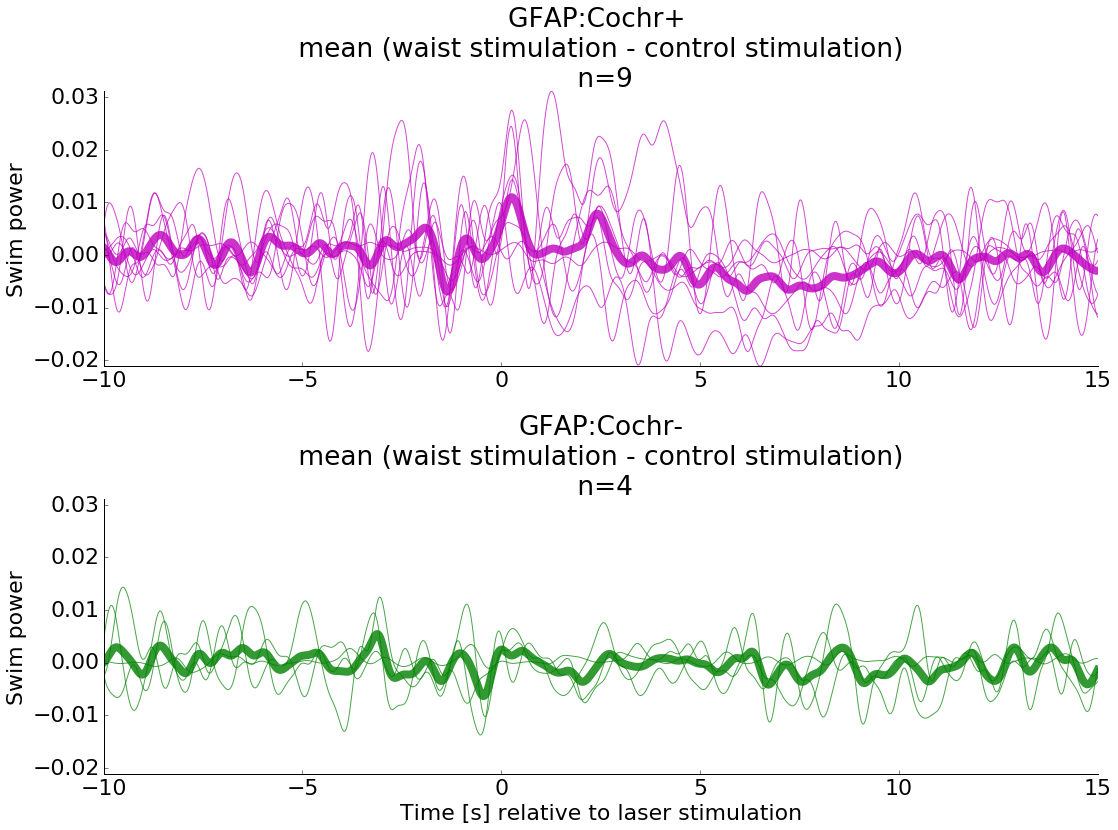

In [79]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
colors = ['m', 'k']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,12), sharey=True)
window_t = window / 6000

axs[0].plot(window_t, (means['pos'][:,0,:] - means['pos'][:,1,:]).T, alpha=.7, color='m')
axs[0].plot(window_t, (means['pos'][:,0,:] - means['pos'][:,1,:]).mean(0), color='m', linewidth=8, alpha=.8)
axs[0].axis('tight')
axs[0].title.set_text('GFAP:Cochr+ \n mean (waist stimulation - control stimulation) \n n={0}'.format(means['pos'].shape[0]))
axs[0].set_ylabel('Swim power')

axs[1].plot(window_t, (means['neg'][:,0,:] - means['neg'][:,1,:]).T, alpha=.7, color='g')
axs[1].plot(window_t, (means['neg'][:,0,:] - means['neg'][:,1,:]).mean(0), color='g', linewidth=8, alpha = .8)
axs[1].axis('tight')
axs[1].title.set_text('GFAP:Cochr-\n mean (waist stimulation - control stimulation) \n n={0}'.format(means['neg'].shape[0]))
axs[1].set_ylabel('Swim power')

axs[-1].set_xlabel('Time [s] relative to laser stimulation')

[axs_format(f) for f in axs]
plt.tight_layout()